In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math

### Data

* Join the tables for W01 and W02. 
* Select features from file and add colors. 
* Check number of members vs non members.
* Split into training, validation and testing samples.

In [3]:
df1 = pd.read_csv('./data/clean-HSC-unWISE-W01.csv')
df1 = df1.drop(columns = [f for f in df1.columns if ('isnull' in f)])
df2 = pd.read_csv('./data/clean-HSC-unWISE-W02.csv')
df2 = df2.drop(columns = [f for f in df2.columns if ('isnull' in f)])
df = pd.concat([df1,df2], axis = 'rows')
del df1,df2

df['gr'] = df['g_cmodel_mag'] - df['r_cmodel_mag']
df['ri'] = df['r_cmodel_mag'] - df['i_cmodel_mag']
df['iz'] = df['i_cmodel_mag'] - df['z_cmodel_mag']
df['zy'] = df['z_cmodel_mag'] - df['y_cmodel_mag']

with open('./data/features1.txt') as file:
    features = file.read().splitlines()
labels = 'member'

n_mem = df[df.member == 1].shape[0]
n_no = df[df.member == 0].shape[0]
n = df.shape[0]
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, stratify = df[labels])
val, test = train_test_split(test, test_size = 0.3, stratify = test[labels])
print ('Training: {} members, {} non members'.format(train[train.member == 1].shape[0], train[train.member == 0].shape[0]))
print ('Validation: {} members, {} non members'.format(val[val.member == 1].shape[0], val[val.member == 0].shape[0]))
print ('Testing: {} members, {} non members'.format(test[test.member == 1].shape[0], test[test.member == 0].shape[0]))

Members: 40237 (16.58%)
Non members: 202456 (83.42%)
Training: 28166 members, 141719 non members
Validation: 8450 members, 42515 non members
Testing: 3621 members, 18222 non members


### SMOTE

#### Resample

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [16]:
# Undersample majority class
rus = RandomUnderSampler(sampling_strategy= 3./7, replacement= False)
rus_feat, rus_lab = rus.fit_resample(train[features], train[labels])

n_mem = len(rus_lab[rus_lab == 1])
n_no = len(rus_lab[rus_lab == 0])
n = len(rus_lab)
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

Members: 28166 (30.00%)
Non members: 65720 (70.00%)


In [17]:
# Oversample minority class with smote
smote = SMOTE(sampling_strategy= 2./3)
smote_feat, smote_lab = smote.fit_resample(rus_feat, rus_lab)

n_mem = len(smote_lab[smote_lab == 1])
n_no = len(smote_lab[smote_lab == 0])
n = len(smote_lab)
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

Members: 43813 (40.00%)
Non members: 65720 (60.00%)


#### Check distributions

In [6]:
# for non members
for f in features:
    plt.figure(figsize=(8,8), dpi=150)
    sns.kdeplot(train[train.member == 0][f], label = 'Original', fill = True, color = 'navy')
    sns.kdeplot(smote_feat[smote_lab == 0][f], label = 'Undersampled', fill = True, color = 'crimson')
    plt.legend()
    plt.grid()
    plt.savefig(f'non_mem_dist/{f}.png', bbox_inches = 'tight')
    plt.close()

In [7]:
# for members
for f in features:
    plt.figure(figsize=(8,8), dpi=150)
    sns.kdeplot(train[train.member == 1][f], label = 'Original', fill = True, color = 'navy')
    sns.kdeplot(smote_feat[smote_lab == 1][f], label = 'SMOTE', fill = True, color = 'crimson')
    plt.legend()
    plt.grid()
    plt.savefig(f'mem_dist/{f}.png', bbox_inches = 'tight')
    plt.close()

In [ ]:
# color-magnitude plots
plt.close()
for m,i in zip(['r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag'],['gr','ri','iz','zy']):
    plt.figure(figsize=(8,8), dpi=150)
    sns.kdeplot(x = train[train.member == 1][i], y = train[train.member ==1][m], color = 'indigo', alpha = 0.7,)
    sns.kdeplot(x = smote_feat[smote_lab == 1][i], y = smote_feat[smote_lab ==1][m], color = 'chocolate', alpha = 0.7)
    plt.grid()
    plt.legend()
    plt.savefig(f'mem_dist/{i}_{m}.png', bbox_inches = 'tight')
    plt.close()

### Model

In [18]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.CSVLogger(filename = 'history.csv'),
    tf.keras.callbacks.ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss',  save_best_only = True),
    # tf.keras.callbacks.TensorBoard()
]

norm = tf.keras.layers.Normalization(input_shape=(len(features),))
norm.adapt(data = smote_feat)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
wei =  compute_class_weight(class_weight = 'balanced', classes = np.unique(smote_lab), y = smote_lab)
weights = {}
for w,l in zip(wei,np.unique(smote_lab)):
    weights[l] = w

del wei
print (weights)

{0: 0.833330797321972, 1: 1.2500057060689749}


In [63]:
model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.GaussianDropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.GaussianDropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.GaussianDropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics=[]
)
# tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name = 'recall')

In [64]:
model.fit(
    x = smote_feat.values, 
    y = smote_lab.values,
    verbose = 2, 
    callbacks = callbacks,
    validation_data = (val[features].values, val[labels].values), 
    epochs = 60,
    batch_size = 4096,
    class_weight = weights
)  


Epoch 1/60
27/27 - 1s - loss: 0.1732 - val_loss: 0.1519 - 1s/epoch - 53ms/step
Epoch 2/60
27/27 - 1s - loss: 0.1631 - val_loss: 0.1558 - 644ms/epoch - 24ms/step
Epoch 3/60
27/27 - 1s - loss: 0.1609 - val_loss: 0.1566 - 692ms/epoch - 26ms/step
Epoch 4/60
27/27 - 1s - loss: 0.1595 - val_loss: 0.1595 - 656ms/epoch - 24ms/step
Epoch 5/60
27/27 - 1s - loss: 0.1587 - val_loss: 0.1595 - 685ms/epoch - 25ms/step
Epoch 6/60
27/27 - 1s - loss: 0.1580 - val_loss: 0.1592 - 646ms/epoch - 24ms/step
Epoch 7/60
27/27 - 1s - loss: 0.1577 - val_loss: 0.1560 - 722ms/epoch - 27ms/step
Epoch 8/60
27/27 - 1s - loss: 0.1572 - val_loss: 0.1587 - 763ms/epoch - 28ms/step
Epoch 9/60
27/27 - 1s - loss: 0.1568 - val_loss: 0.1582 - 749ms/epoch - 28ms/step
Epoch 10/60
27/27 - 1s - loss: 0.1565 - val_loss: 0.1596 - 869ms/epoch - 32ms/step
Epoch 11/60
27/27 - 1s - loss: 0.1562 - val_loss: 0.1601 - 806ms/epoch - 30ms/step
Epoch 12/60
27/27 - 1s - loss: 0.1559 - val_loss: 0.1583 - 792ms/epoch - 29ms/step
Epoch 13/60
27/2

In [65]:
# load best model and training history
model = tf.keras.models.load_model('model.h5')
history = pd.read_csv('history.csv')

### Tests

* Training and validation loss plot
* Confusion matrix plot
* ROC curve plot
* Loss on test sample
* ROC & precision-recall AUC 
* Precision, recall, F1...


In [66]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

pred = model.predict(test[features], verbose = 0)
pred_classes = np.round(pred, decimals = 0)

test_loss = model.evaluate(test[features], test[labels], verbose=0)
fpr, tpr, thresholds_roc = roc_curve(test[labels], pred, pos_label=1)
precision, recall, thresholds_pr = precision_recall_curve(test[labels], pred, pos_label= 1)

# def model_write(string):
#     file.write(string + '\n')

# with open('report.txt', mode='x') as file:
#     model.summary(print_fn= model_write)
#     file.write('\n\n')
#     file.write('Optimizer: {} \n'.format(model.optimizer))
#     file.write('Loss function: {} \n'.format(model.loss))
#     file.write('Notes: \n')
#     file.write('-'*70 + '\n')
#     file.write('Loss on test dataset: {:.4g} \n'.format(test_loss))
#     file.write('AUC: {}\n'.format(auc(fpr, tpr)))
#     file.write('-'*70 + '\n')
#     file.write(classification_report(test[labels],pred_classes))

print('Loss on test dataset: {:.4g} \n'.format(test_loss))
print('ROC AUC: {}\n'.format(auc(fpr, tpr)))
print('Precision-recall AUC: {}\n'.format(auc(recall, precision)))
print('-'*70 + '\n')
print(classification_report(test[labels],pred_classes))

Loss on test dataset: 0.01688 

ROC AUC: 0.7211329455964731

Precision-recall AUC: 0.3271516665423454

----------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.89      0.79      0.84     18222
           1       0.32      0.50      0.39      3621

    accuracy                           0.74     21843
   macro avg       0.61      0.65      0.61     21843
weighted avg       0.79      0.74      0.76     21843



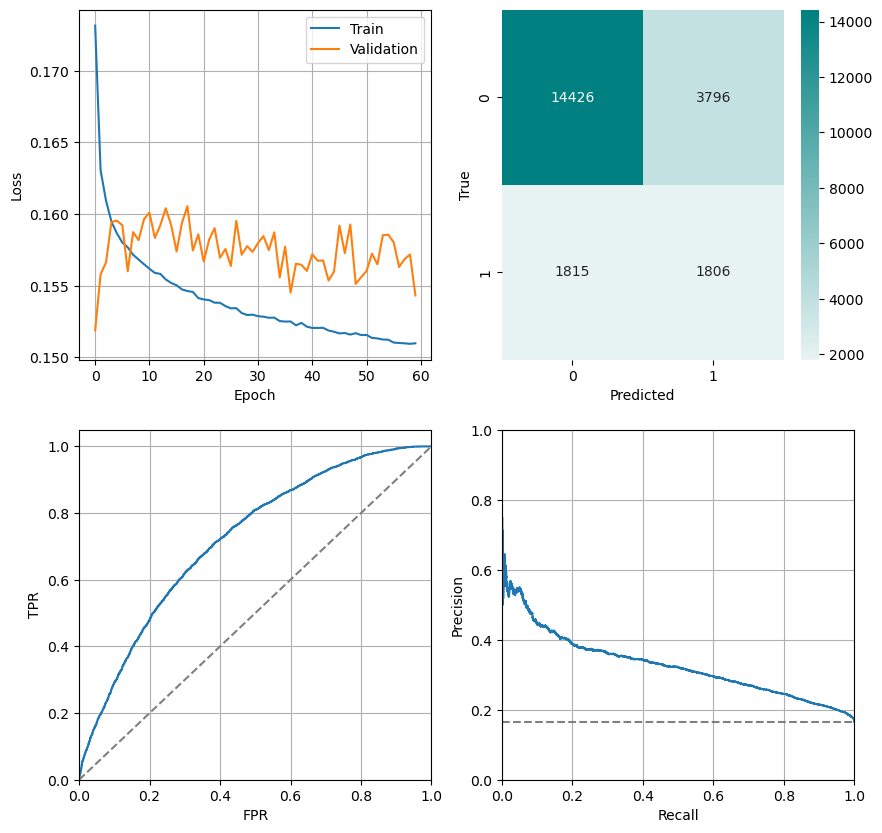

In [67]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))

# Loss during training
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

# Confusion matrix
plt.subplot(2, 2, 2)
conf_m = confusion_matrix(test[labels], pred_classes)
df_conf_m = pd.DataFrame(conf_m, index=[0,1], columns=[0,1])
sns.heatmap(df_conf_m, cmap=sns.color_palette('light:teal', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

# ROC Curve
plt.subplot(2, 2, 3)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# Precision-recall curve
plt.subplot(2, 2, 4)
plt.plot(recall, precision)
plt.plot([0, 1], [len (test[test.member == 1])/len(test), len (test[test.member == 1])/len(test)] , color='gray', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

# plt.savefig('fig.png', dpi=150, bbox_inches= 'tight')
plt.show()

### Thresholds

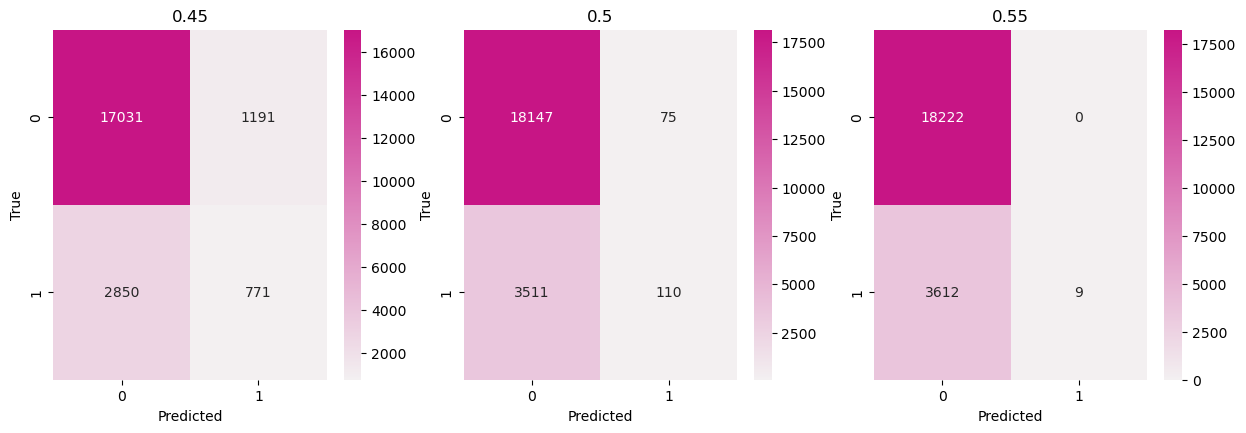

In [37]:
# get predictions with different thresholds

pred_c_thres = []
thresholds = [0.45,0.5,0.55]

for t in thresholds:
    pred_c_thres.append(
        [math.floor(p[0]) if p[0] < t else math.ceil(p[0]) for p in pred]
    )
    
# plot conf matrix for each
plt.figure(figsize=(15,10))

for i,(p,t) in enumerate(zip(pred_c_thres,thresholds)):
    plt.subplot(2, 3, i+1)
    plt.title(t)
    c = confusion_matrix(test[labels], p)
    c = pd.DataFrame(c, index=[0,1], columns=[0,1])
    sns.heatmap(c, cmap=sns.color_palette('light:mediumvioletred', as_cmap=True), annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
# plt.savefig('fig.png', dpi=150, bbox_inches= 'tight')
plt.show()

Best Threshold=0.380294, G-Mean=0.668


Text(518.4494949494949, 0.5, 'True')

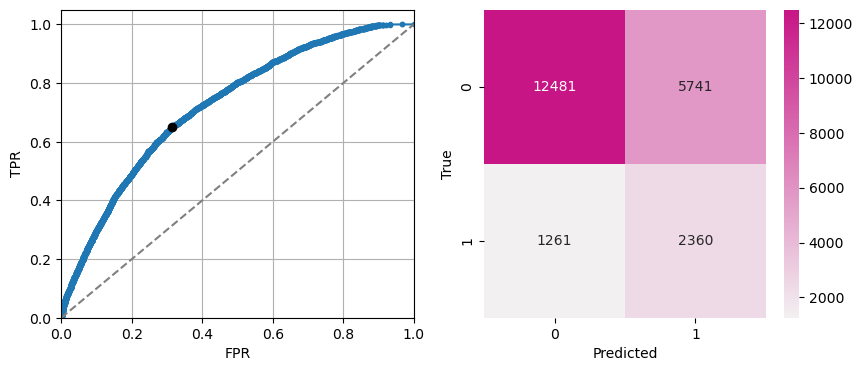

In [35]:
# With G-Mean
# calculate the g-mean for each threshold
gmeans = (tpr * (1-fpr))**(1/2)

# locate the index of the largest g-mean
max_gmeans = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[max_gmeans], gmeans[max_gmeans]))

# ROC Curve
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker = '.')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.plot(fpr[max_gmeans], tpr[max_gmeans], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# Conf matrix
pred_gmeans = [math.floor(p[0]) if p[0] < thresholds_roc[max_gmeans] else math.ceil(p[0]) for p in pred]
plt.subplot(1, 2, 2)
c = confusion_matrix(test[labels], pred_gmeans)
c = pd.DataFrame(c, index=[0,1], columns=[0,1])
sns.heatmap(c, cmap=sns.color_palette('light:mediumvioletred', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

Best Threshold=0.390969, F-Score=0.405


Text(518.4494949494949, 0.5, 'True')

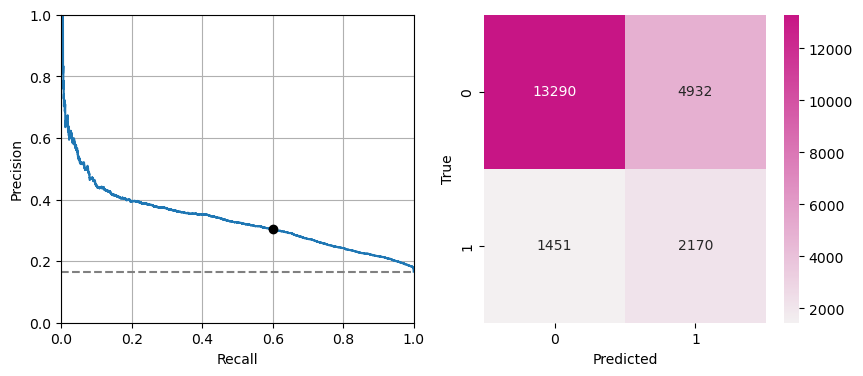

In [36]:
# with f-score
fscore = (2 * precision * recall) / (precision + recall)
max_f = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_pr[max_f], fscore[max_f]))

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(recall, precision)
plt.plot(recall[max_f], precision[max_f], marker='o', color='black', label='Best')
plt.plot([0, 1], [len (test[test.member == 1])/len(test), len (test[test.member == 1])/len(test)] , color='gray', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

# Conf matrix
pred_f = [math.floor(p[0]) if p[0] < thresholds_pr[max_f] else math.ceil(p[0]) for p in pred]
plt.subplot(1, 2, 2)
c = confusion_matrix(test[labels], pred_f)
c = pd.DataFrame(c, index=[0,1], columns=[0,1])
sns.heatmap(c, cmap=sns.color_palette('light:mediumvioletred', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
